# 1. Soft SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

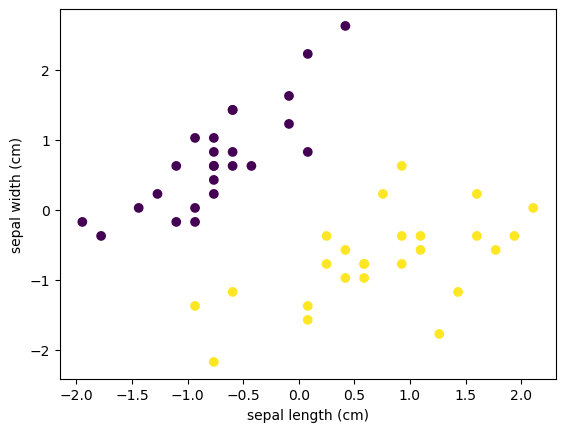

In [4]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.02064204216003418
Optimal objective value: 3.509302958519576
SCS solver iterations: 425
SCS solve time: 0.00197462
SCS setup time: 0.0060856719999999994
Optimal w:  [ 1.9399641  -1.80420157]
Optimal b:  [0.32852456]
Dual variables (Lagrange multipliers): [ 0.          3.50930227  0.          0.          2.95766995  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.55163229
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-2.3278685   0.00000009 -0.9180326  -1.7704916   0.0000001  -1.2786883
 -1.639344   -1.5409833  -0.9508195  -2.491803   -1.2131145  -2.1311471
 -0.49180314 -3.3770487  -

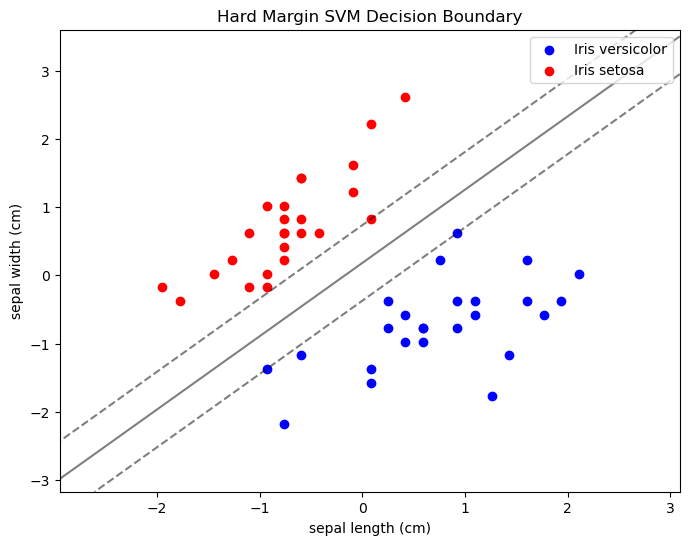

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj


def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [9]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    
    return sol, result, evalutation(result)

# 3. The method

In [10]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [11]:
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

1st ITERATION:

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj = solve_ODE(xu0, T)
    
    if obj == np.inf:
        print('No feasible solution found.')
        lastIter = False
    else:
        print('Feasible solution found: ', obj)
        lastIter = True

    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if lastIter and L_epsilon[-1] != np.inf:
        net = net_best
    else:
        net = net_curr
        lastIter = False
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj = evalutation(res)
    
    print('PINN objective value:', pinn_obj)
    
    return res, pinn_obj, lastIter
    
        

In [13]:
NBATCH = 1024
WEIGTHING = 1
LAYERS = 3
NEURONS = 200
LR = 0.005
T = 50.0

>>>> ITERATION: 0
Time: 6.625534772872925
objective: inf
Dual variables (alpha): [ 1.8388947  -1.74247213  0.34937196  0.00000041  0.03173058  0.0000004
  0.00000037  0.01718077  0.0000004   0.00000037  0.00000015  0.00000024
  0.00000016  0.00000035  0.00000016 -0.00000046  0.00000016  0.00000025
 -0.00000047  0.00000029  0.00000013  0.0000002  -0.00000031  0.00000036
  0.00000022  0.00000046 -0.00000044  0.00000046  0.00000034  0.00000037
  0.00000036  0.00000042  0.00000016  0.00000016  0.0000004   0.00000037
  0.00000039  0.00000029  0.00000025  0.00000042 -0.0297558   0.00000025
  0.0000004   0.00000038 -0.01523152  0.00000016  0.00000037  0.00000016
  0.00000016  0.00000037  0.00000016  0.00000036  0.00000036]
Constraints: [-2.2432814   0.03175682 -0.79381734 -1.6405648   0.01707912 -1.1421335
 -1.4904495  -1.3778629  -0.831346   -2.3664243  -1.1608042  -2.0181084
 -0.3704427  -3.1862     -1.7823787  -0.35158458 -1.2652766  -0.4455009
 -1.7637079  -0.30349916 -1.7073212  -1.89496

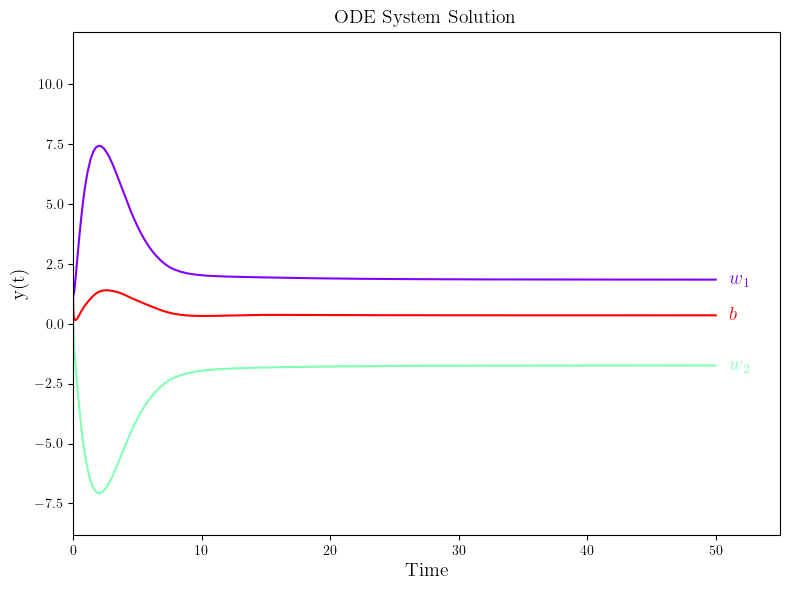

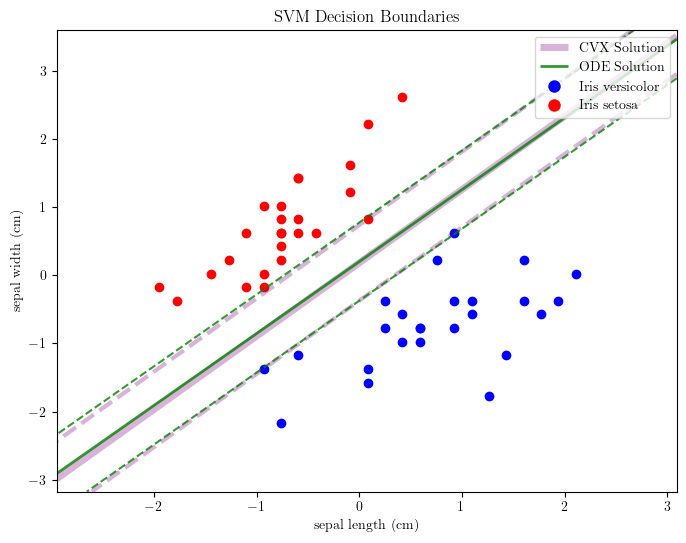

epsilon: 225.73938 time: 18059.570407152176 iterations: 20000


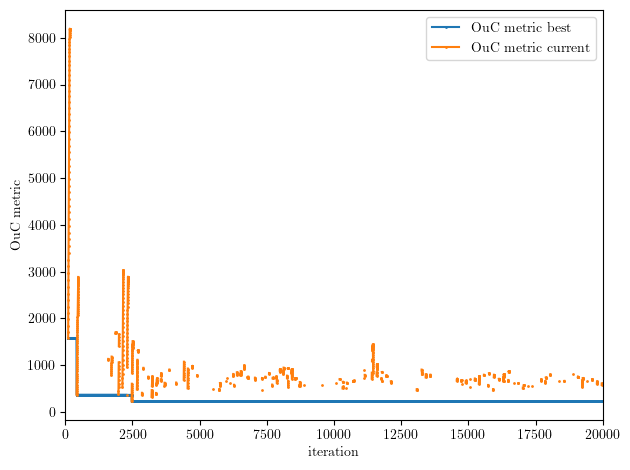

Last losses: [53.085914611816406, 51.073944091796875, 47.45956802368164, 43.280216217041016, 37.87287139892578, 33.73945617675781, 31.203330993652344, 30.673503875732422, 32.38138961791992, 35.34849548339844]


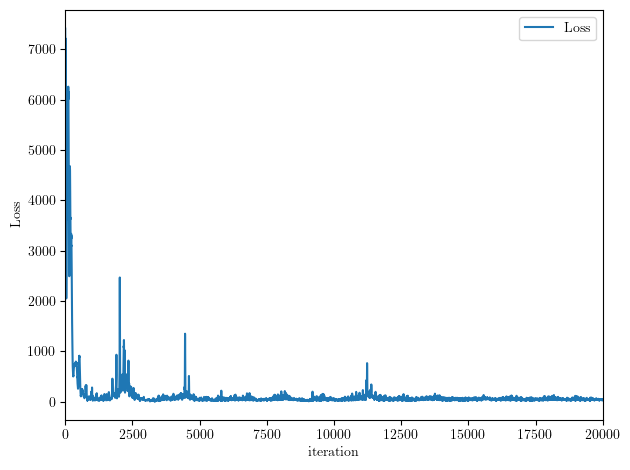

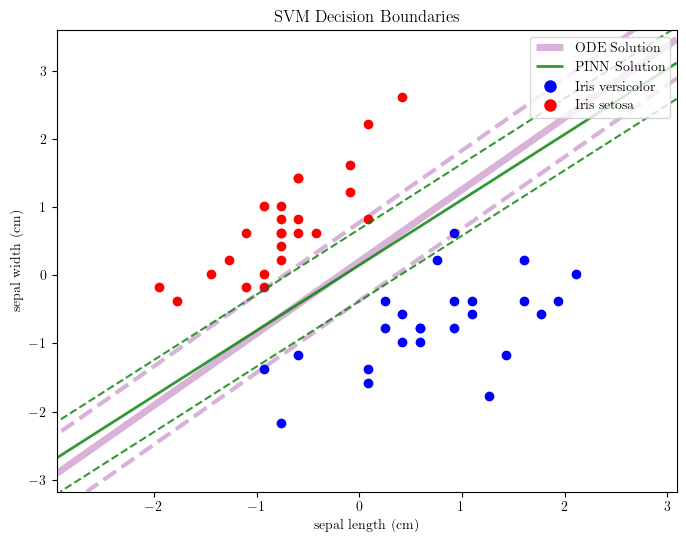

Variables: [ 1.8167996  -1.892695    0.2803409   1.1941042   0.21639797  0.6412564
  1.602673    0.4508943   1.8354379   1.8217361   1.5131717   1.5285611
  1.1978098   0.87663484  1.2569854   0.18578798  0.25742722  0.16990845
  0.29649073  2.0317113   0.85633683  0.95914906 -0.41840744  1.5322273
  1.7124834   0.66334796 -0.81565017  0.77643603 -0.80087346  1.0335376
  0.43833935  0.45183766  0.6936764   0.8608877   1.86681     1.0614319
  2.0192752   0.7135211   1.6708934   0.59156847  0.9423171   0.850854
  0.48568282  1.7258899  -0.29866156  0.5114276   1.6944014   0.66834354
  0.2538337   0.21696776  0.8702833   1.7470307   0.17331856]
Constraints: [-3.6031919  -0.34745434 -1.5508875  -3.5541637  -0.23344867 -3.1234143
 -3.4880579  -2.9656167  -2.5094845  -3.5574892  -2.079394   -3.2383196
 -0.5744893  -3.3243892  -1.986774   -0.5286827  -3.2702796  -1.3876226
 -2.8612316  -0.00577714 -3.2065084  -3.7432256  -1.7948151   0.35565662
 -3.6984942   0.35480478 -3.8130112  -2.9326441 

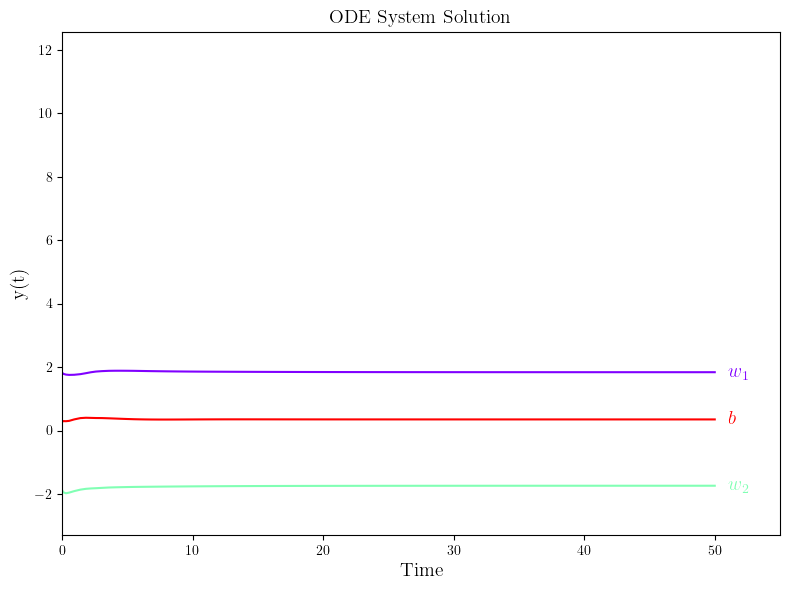

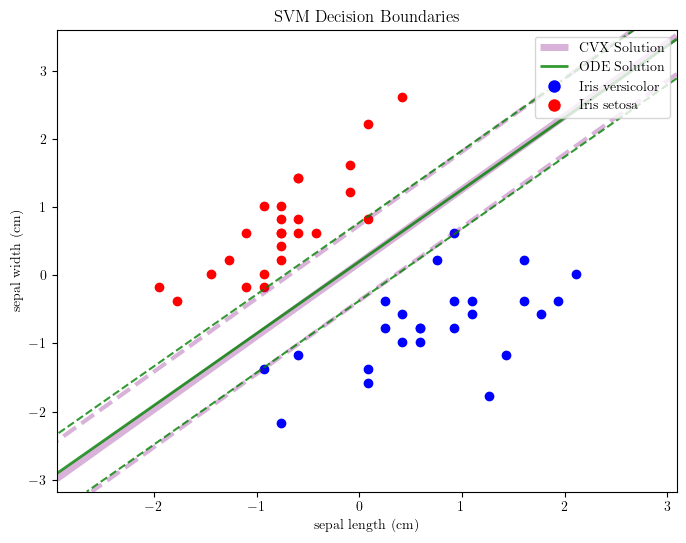

epsilon: inf time: 15744.826751232147 iterations: 20000


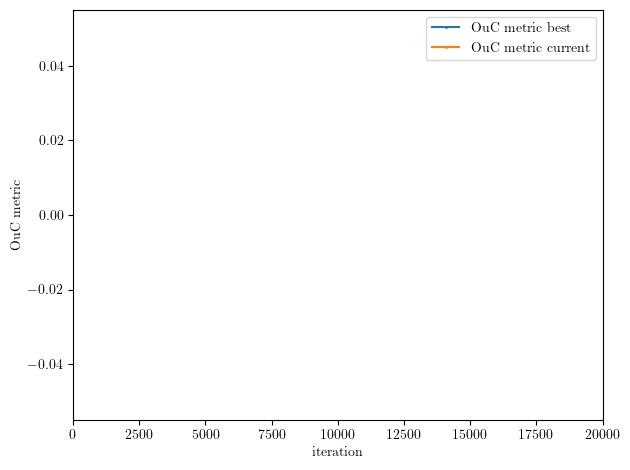

Last losses: [5.144129753112793, 4.826006889343262, 4.540680408477783, 4.268222808837891, 3.990119457244873, 3.974519729614258, 3.986278533935547, 4.221531867980957, 4.3917036056518555, 4.693755149841309]


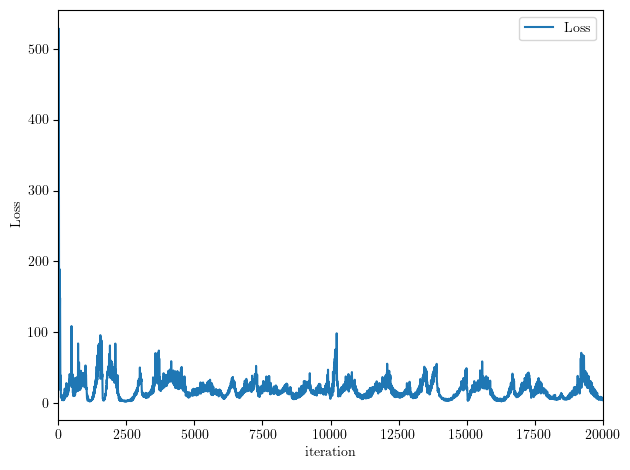

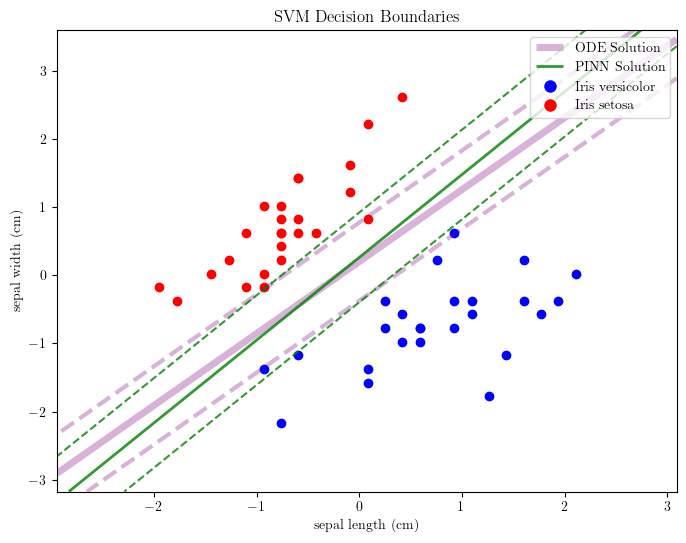

Variables: [ 1.8463597  -1.5200241   0.3992521   0.38899255 -0.2821057  -0.22393417
  0.46909928 -0.4112112   0.62466025  0.10353982  0.42719913  0.04227495
  0.00390363  0.38881278 -0.32536423 -0.11609828  0.22567277  0.47427142
 -0.1777246   0.35212493 -0.06193113 -0.21289879  0.15716118  0.03280056
 -0.09933341 -0.14469838  0.3176853   0.15965998  0.11793905  0.1605643
  0.06112942  0.26995206  0.5628967  -0.06645375 -0.11582863  0.02429128
  0.14777899  0.62123305  0.46021593  0.13594365  0.24924529  0.16220385
  0.46877432  0.10008311  0.29629198  0.22824031  0.21475685  0.30044258
 -0.06467476  0.09298982 -0.11511856 -0.19005406 -0.34848642]
Constraints: [-2.3323605   0.5792823  -0.43143553 -1.6993688   0.24994054 -1.5838792
 -1.3666081  -1.7148664  -0.68944496 -2.300319   -1.4288325  -1.6672018
 -0.25182152 -3.482834   -2.138389   -0.27919564 -1.6643913  -0.2895893
 -1.3704181  -0.24463469 -1.7133176  -1.5401852  -0.90352106 -0.6774054
 -1.973029   -0.55026025 -1.9903327  -1.923

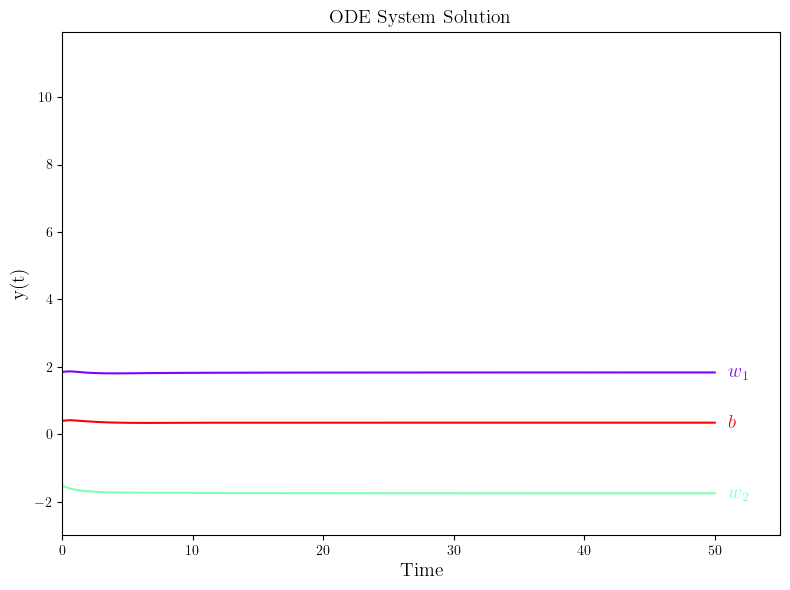

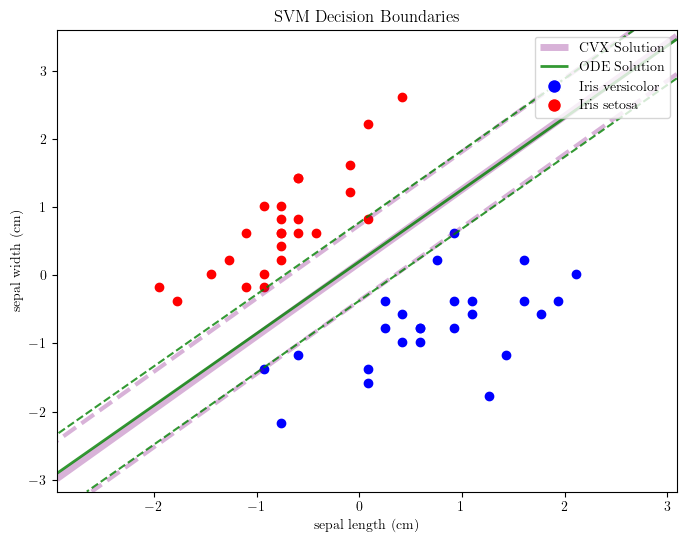

epsilon: inf time: 14298.126870393753 iterations: 20000


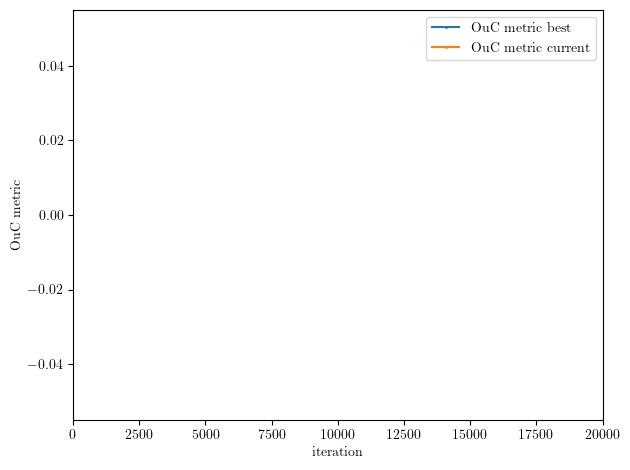

Last losses: [3.996145725250244, 3.848724126815796, 3.8619565963745117, 4.022228240966797, 4.501090049743652, 5.137094497680664, 5.804465293884277, 6.359965801239014, 7.0377888679504395, 7.518680572509766]


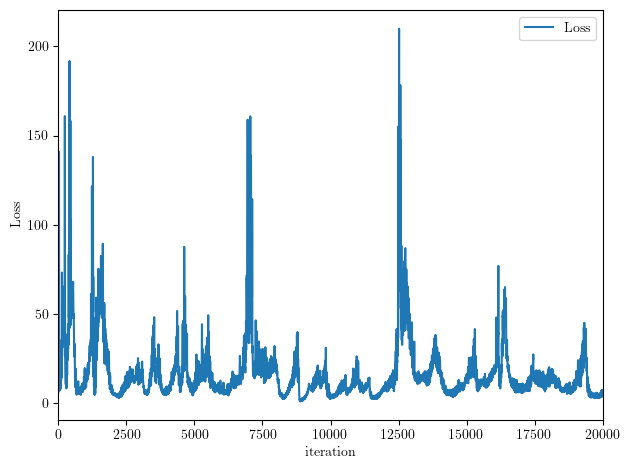

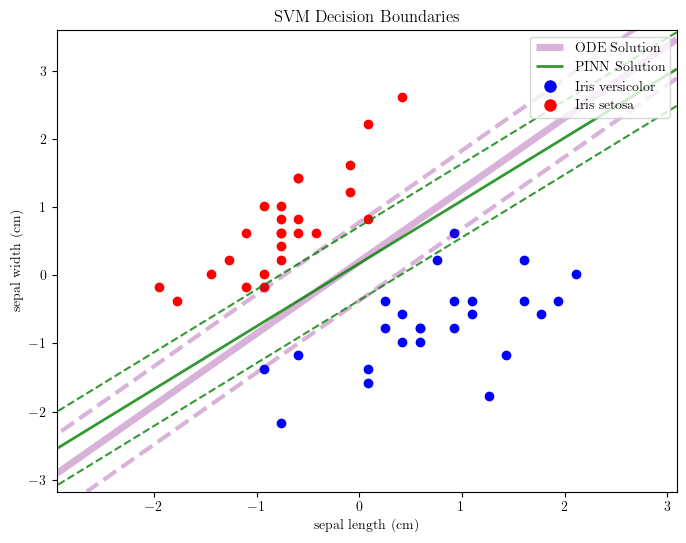

Variables: [ 1.7055492  -1.8492931   0.32097635  0.15047425  0.5513668   0.44399285
  0.14803195  0.35502154 -0.10603988 -0.08185658  0.3288306  -0.1066135
  0.31182623 -0.17171091  0.21903324 -0.20800911  0.00870909 -0.03134382
  0.17632431  0.2977748   0.27242407  0.30567878  0.26895723  0.16560629
  0.05830356 -0.11461658  0.3726327   0.12967597 -0.1966553   0.17647195
  0.03547044  0.42914063 -0.08312142 -0.08808523 -0.01745121 -0.02868828
 -0.03628197 -0.18362302 -0.08195895 -0.22607204 -0.53089976  0.12985119
 -0.05169821 -0.2691941  -0.44559357 -0.34847552 -0.23222375  0.4907314
 -0.5210832  -0.47131628 -0.17985907  0.12863985 -0.37402296]
Constraints: [-2.522806   -0.61506796 -1.2096097  -1.9786617  -0.10224435 -1.0292464
 -1.4230992  -1.5895308  -0.7404219  -2.5653164  -1.0101941  -2.102854
 -0.02510141 -2.8826964  -1.727063   -0.374635   -1.3142196  -0.66837156
 -2.017467   -0.7489464  -1.7611761  -2.0609658  -0.9858699  -0.68716174
 -2.9438999  -0.24591087 -2.827859   -2.361

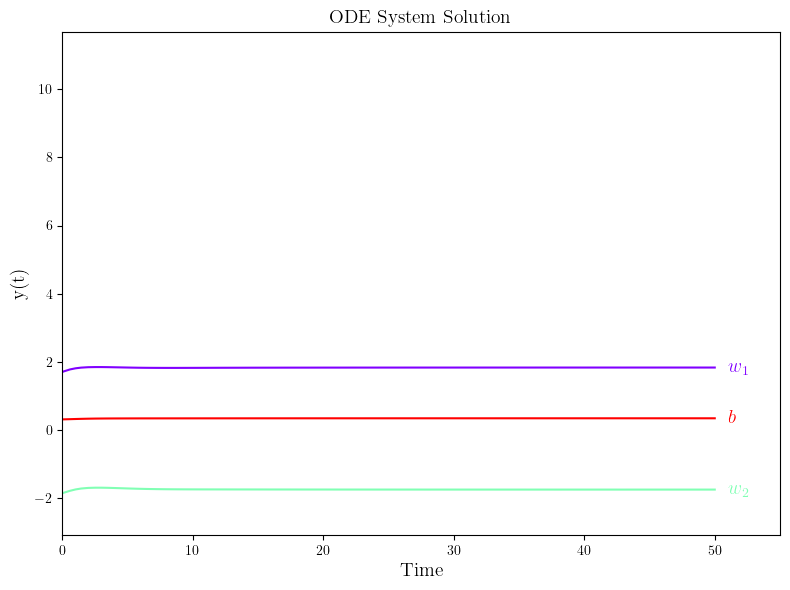

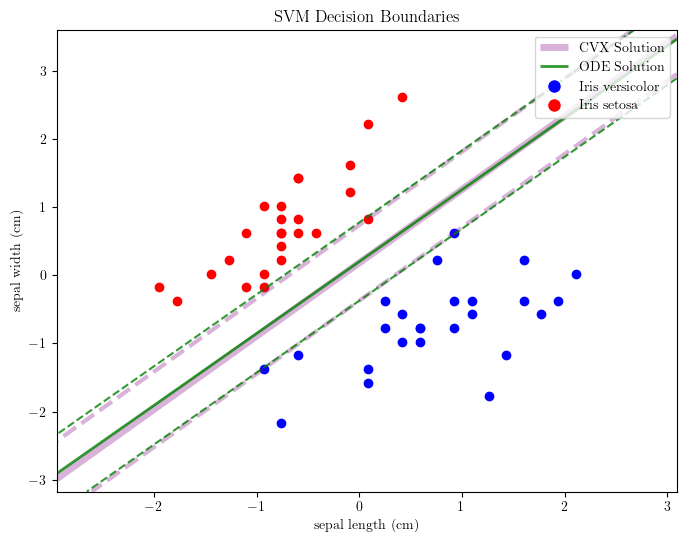

epsilon: inf time: 14137.329744577408 iterations: 20000


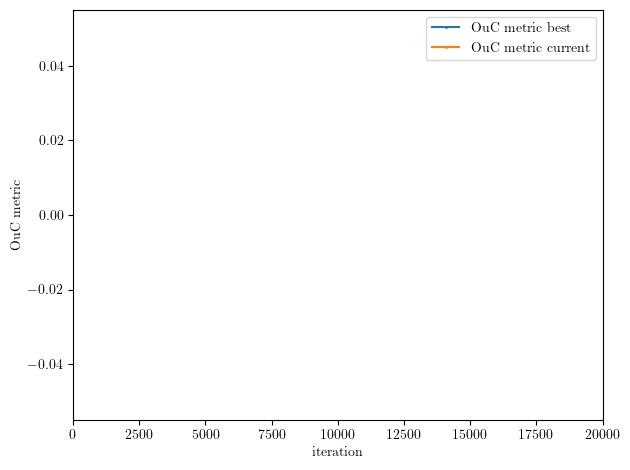

Last losses: [7.381952285766602, 7.084052085876465, 6.682077407836914, 6.3371992111206055, 6.255672931671143, 6.107512474060059, 6.183995723724365, 6.444016933441162, 6.855922698974609, 7.385507583618164]


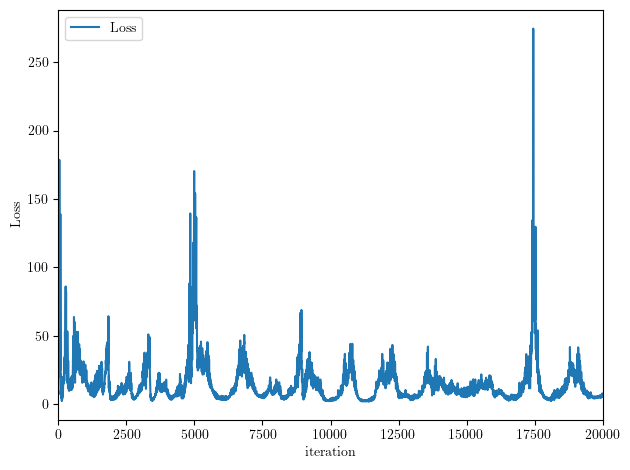

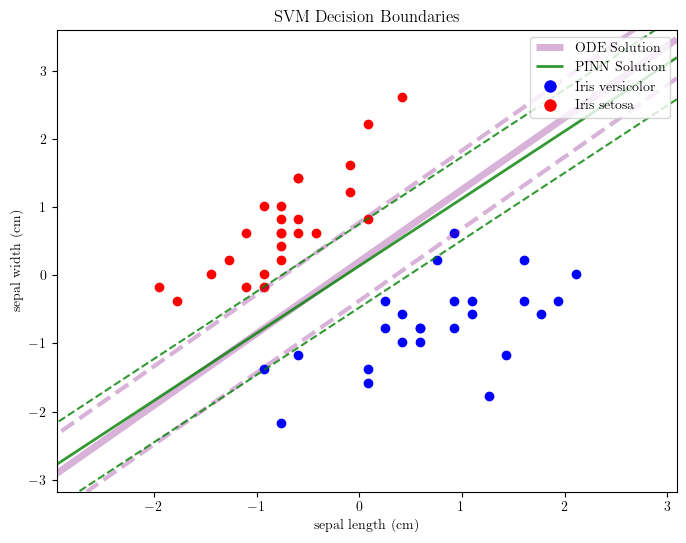

Variables: [ 1.6158366  -1.6348557   0.22421767  0.7014968  -0.08963513 -0.20251954
 -0.22135547  0.16832612  0.5402045   0.55482924 -0.05260465 -0.12497849
  0.37447828  0.17171484 -0.37275112  0.48766273 -0.33378547  0.4693218
 -0.3191843   0.6004636   0.49175996  0.14815208 -0.34119293 -0.5437039
 -0.2678866   0.12417901  0.53780407  0.4336416   0.35491052  0.44589168
 -0.58123446  0.08261099  0.7069916   0.3116901   0.59546936  0.86626023
  0.5978049  -0.16902658  0.04042917 -0.44828174 -0.01182234 -0.56018007
 -0.6835107  -0.5171209   0.02857026  0.662661    0.05396932 -0.22469464
  0.23018742 -0.62993777 -0.17139426 -0.03774056 -0.53724146]
Constraints: [-2.6320117   0.09850349 -0.50044835 -1.3500805   0.13055772 -1.5699762
 -1.9114048  -1.1428257  -0.63170445 -2.3095064  -1.068103   -1.2354732
 -0.7563966  -2.259364   -1.9118874   0.23754919 -1.6347487  -0.867924
 -1.7241014   0.15664105 -0.7914316  -1.3358243  -0.966852   -0.860253
 -2.8198304  -0.5976909  -2.7246504  -1.482664

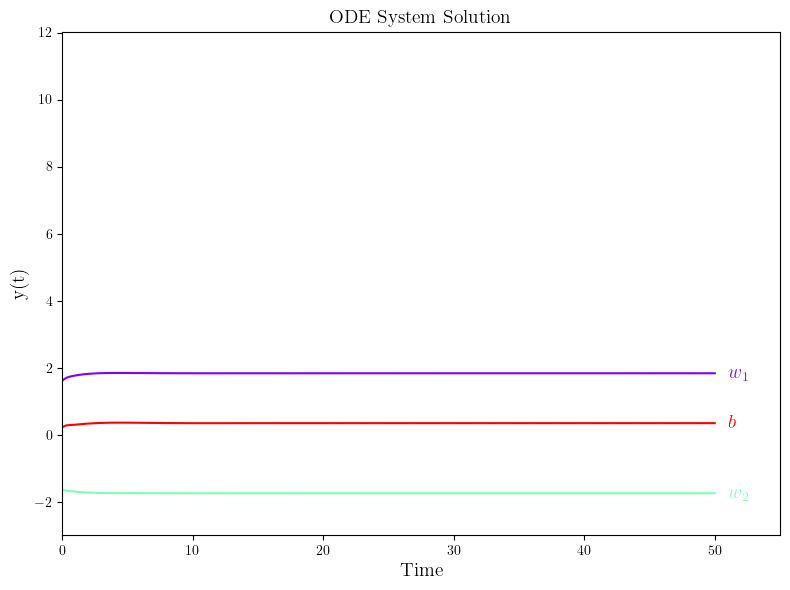

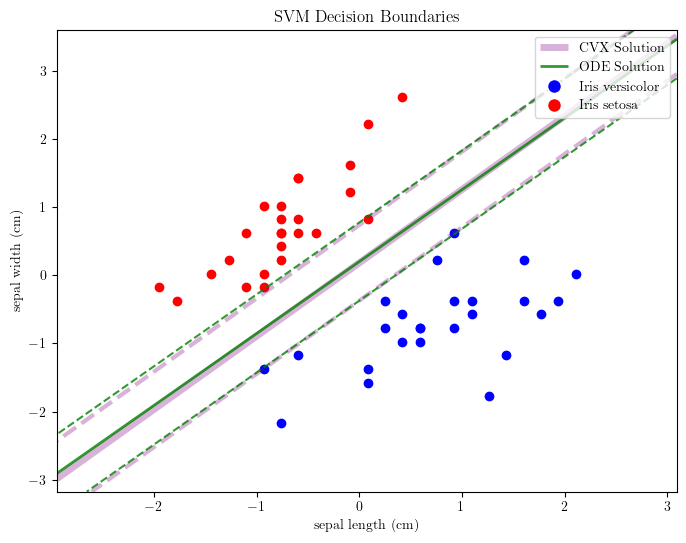

KeyboardInterrupt: 

In [14]:
ITERATIONS = 20000
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(10):
    print('>>>> ITERATION:', i)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res

In [ ]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

y0 = np.zeros(NY)
y0[:nw + nb] = 1.0



Time: 1.5237305164337158
objective: inf
Dual variables (alpha): [ 1.30350893 -0.88004458  0.67199496  0.05179817  0.12932325  0.05025412
 -0.22220185  0.13577428  0.1391375   0.13162722  0.13193892  0.1391375
  0.0456218 ]
Constraints: [-0.06937535 -3.2801313  -0.07072999 -0.23432095 -0.585026   -1.4242252
 -0.5576895  -1.6169212  -1.4242252  -0.07479372 -0.05179817 -0.12932324
 -0.05025412  0.22220185 -0.13577428 -0.1391375  -0.13162722 -0.13193892
 -0.1391375  -0.0456218 ]
max diff: 1.1134615 mean diff: 1.1134615


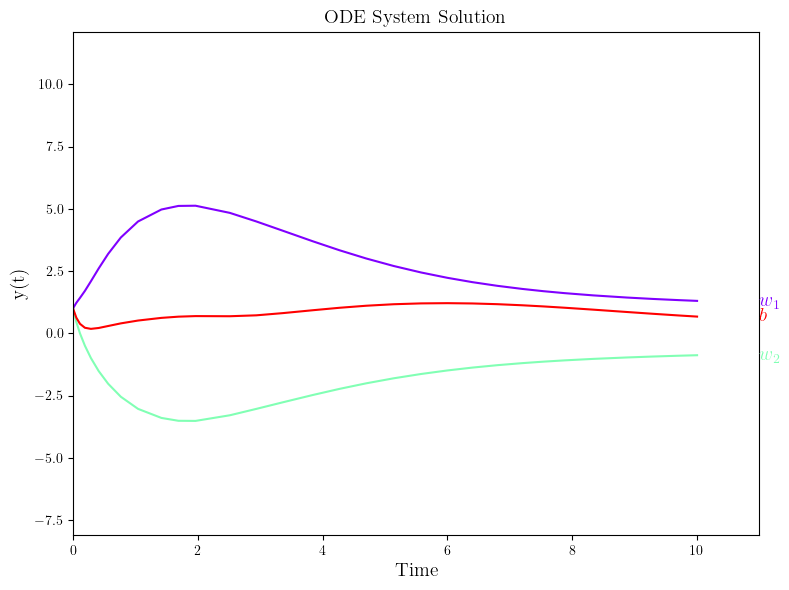

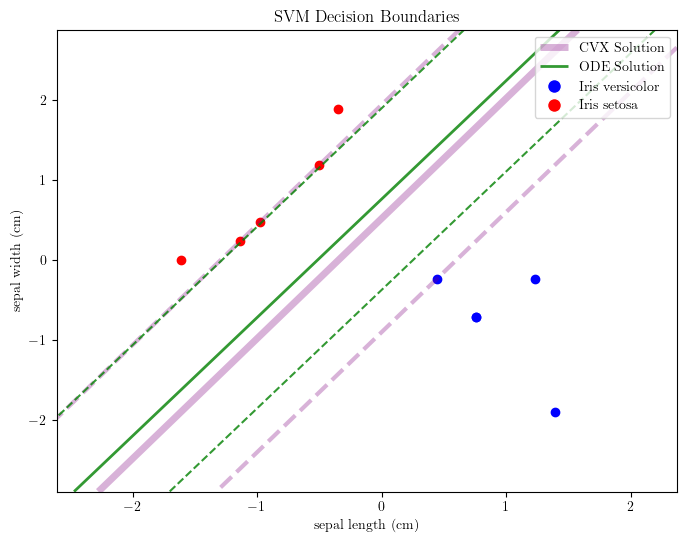

In [ ]:

sol, result = solve_ODE(xu0, T)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [14]:
T=20.0

In [15]:
NBATCH = 512
ITERATIONS = 5000
WEIGTHING = 1

In [16]:
LAYERS = 2
NEURONS = 100
LR = 0.001
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t = example.NN_method() # train
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'time:', t)
res_1 = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net_best': net_best, 'net_curr': net_curr, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'time': time}


LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 36.792313 time: 456.8022027015686


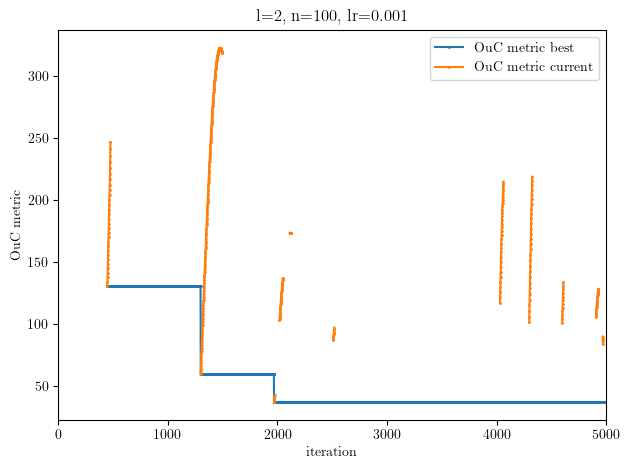

In [17]:
plt.plot(res_1['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res_1['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

[7.614572525024414, 7.605794906616211, 7.397608757019043, 7.453720569610596, 7.464633941650391, 7.3125152587890625, 7.404053688049316, 7.3551154136657715, 7.29149055480957, 7.485804557800293]


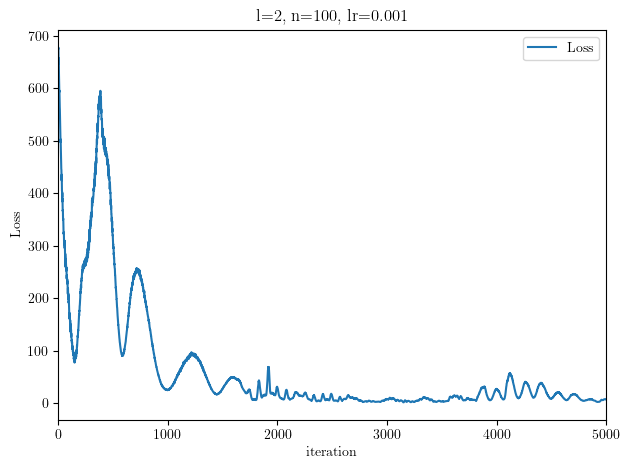

In [18]:
print(L_loss[-10:])

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

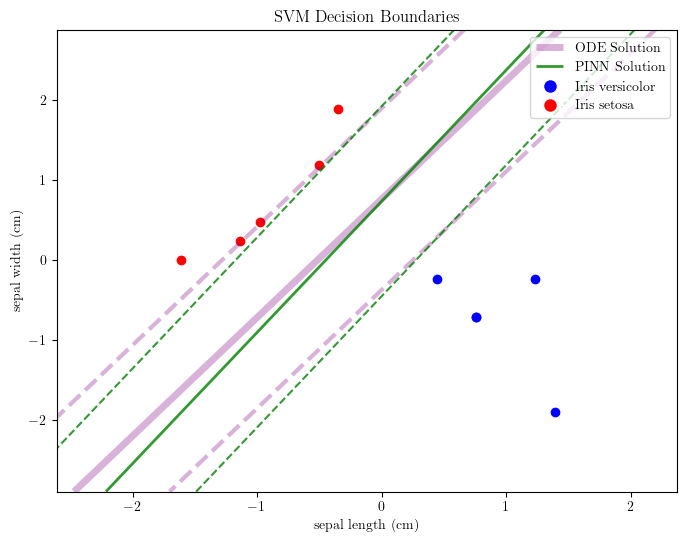

Variables: [ 1.380197   -0.8413477   0.61992466  0.41472882  0.37288076  0.3557058
  0.63668334  0.34223676  0.01244165  0.28257737  0.12702581  0.5464529
  0.45785785]
Constraints: [-0.56233346 -3.5047336  -0.4849358  -1.0658474  -0.79680526 -1.2760291
 -0.88414294 -1.6451557  -1.8100404  -0.53196394 -0.41472882 -0.37288076
 -0.3557058  -0.63668334 -0.34223676 -0.01244165 -0.28257737 -0.12702581
 -0.5464529  -0.45785785]


In [19]:
net = res_1['net_best']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))

2nd ITERATION:

In [20]:
xu0 = jnp.array(res_)

y0 = res_

Time: 0.3993499279022217
objective: 0.79530585
Dual variables (alpha): [ 1.05493052 -0.70470193  0.36693817  0.00049318 -0.00009787  0.00021506
 -0.00041445 -0.00009926 -0.000101   -0.00009549 -0.00009727 -0.0001277
 -0.00061878]
Constraints: [ 0.00085539 -2.167989    0.00056969  0.00033953 -0.33543202 -0.6669678
 -0.33092526 -0.83231044 -0.6669411  -0.00028793 -0.00049318  0.00009787
 -0.00021506  0.00041445  0.00009926  0.000101    0.00009549  0.00009727
  0.0001277   0.00061878]
max diff: 0.0024281442 mean diff: 0.0024281442


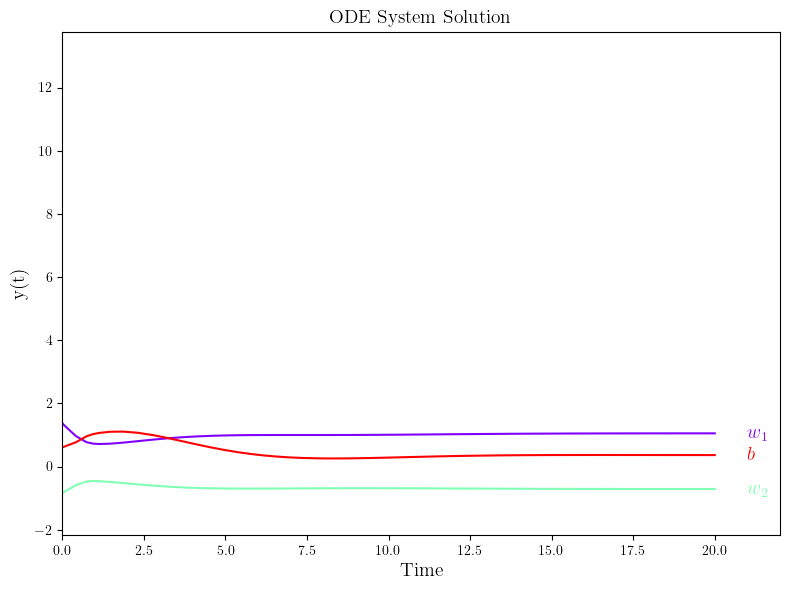

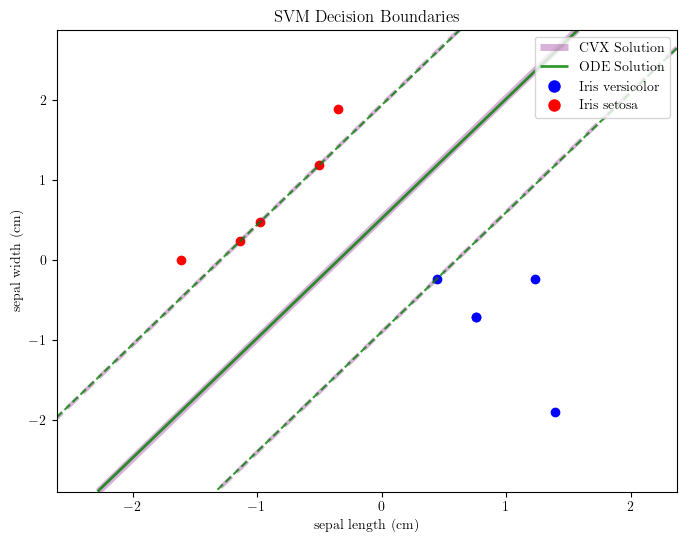

In [21]:
sol, result = solve_ODE(xu0, 20)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [22]:
ITERATIONS = 10000

In [23]:
LAYERS = 2
NEURONS = 100
LR = 0.001
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t = example.NN_method() # train
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'time:', t)
res_2 = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net_best': net_best, 'net_curr': net_curr, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 4.290126 time: 906.760507106781


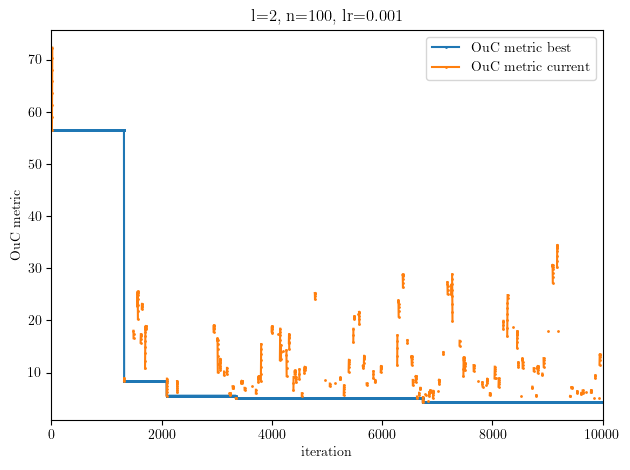

In [24]:
plt.plot(res_2['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res_2['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res_2["layers"]}, n={res_2["neurons"]}, lr={res_2["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

[0.04633723199367523, 0.05213646590709686, 0.06019759178161621, 0.0707695484161377, 0.07924312353134155]


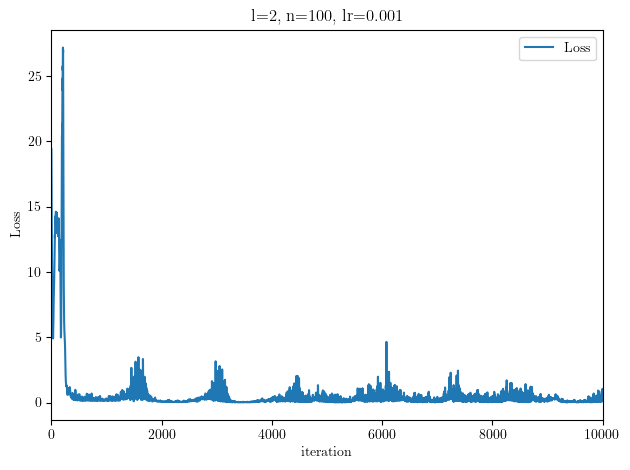

In [27]:
print(L_loss[2000:2005])

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res_2["layers"]}, n={res_2["neurons"]}, lr={res_2["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

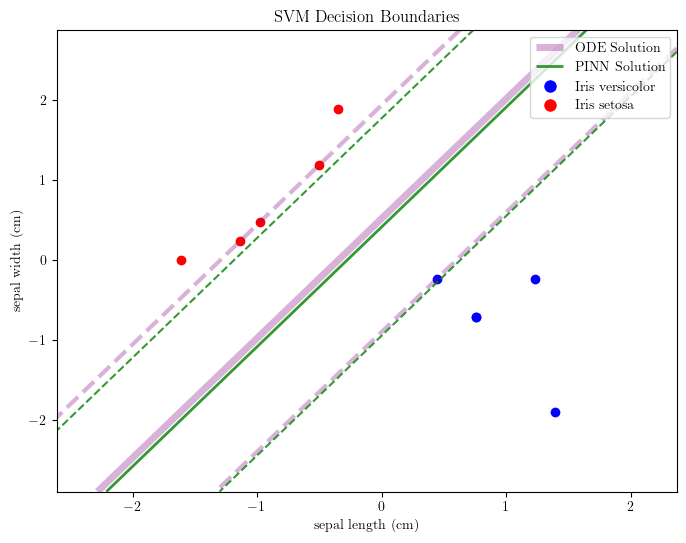

Variables: [ 1.1010644  -0.73518777  0.30515772 -0.02561939 -0.03708696 -0.03891313
 -0.00010431  0.03233248 -0.09864503  0.02817646  0.00130691 -0.00375259
 -0.05539894]
Constraints: [-0.09445339 -2.1910892  -0.08166943  0.03420037 -0.5034666  -0.5632642
 -0.4952323  -0.835943   -0.65815663 -0.06671298  0.02561939  0.03708696
  0.03891313  0.00010431 -0.03233248  0.09864503 -0.02817646 -0.00130691
  0.00375259  0.05539894]


In [26]:
net = res_2['net_curr']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))

3rd ITERATION:

In [35]:
xu0 = jnp.array(res_)

y0 = res_

Time: 0.32210779190063477
objective: 0.80472875
Dual variables (alpha): [ 1.05569047 -0.70393365  0.36670629  0.00020124  0.0000006   0.00007433
  0.00000857  0.00000029 -0.0000005   0.00000421 -0.00000682 -0.00000285
 -0.00030645]
Constraints: [ 0.00023413 -2.1674542   0.00009923 -0.00000528 -0.33457047 -0.6668657
 -0.33248    -0.8329223  -0.6668634  -0.00030538 -0.00020124 -0.0000006
 -0.00007433 -0.00000857 -0.00000029  0.0000005  -0.00000421  0.00000682
  0.00000285  0.00030645]
max diff: 0.0012639165 mean diff: 0.0012639165


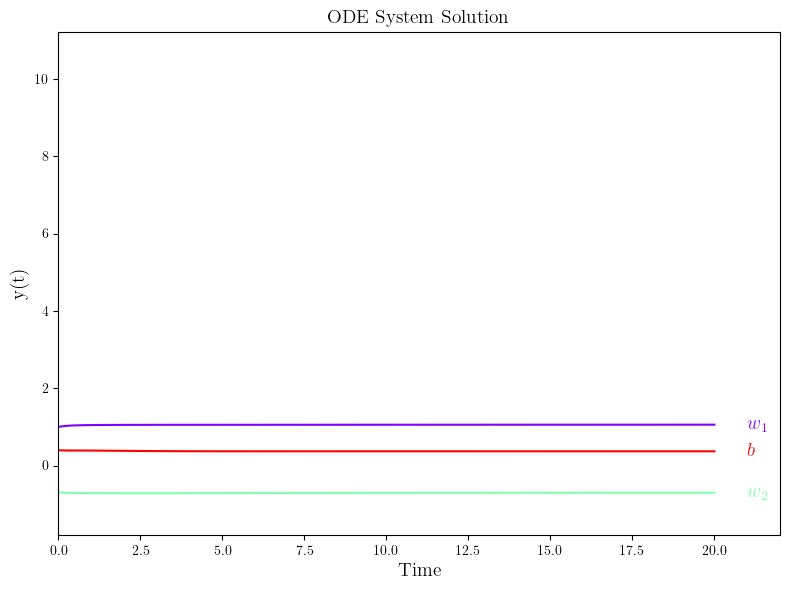

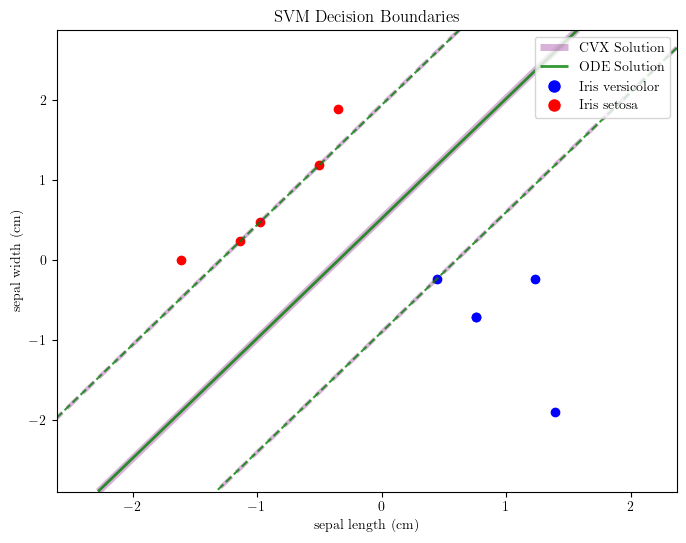

In [36]:
sol, result = solve_ODE(xu0, 20)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [28]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t = example.NN_method() # train
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'time:', t)
res_3 = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net_best': net_best, 'net_curr': net_curr, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 44.392582 time: 413.6143352985382


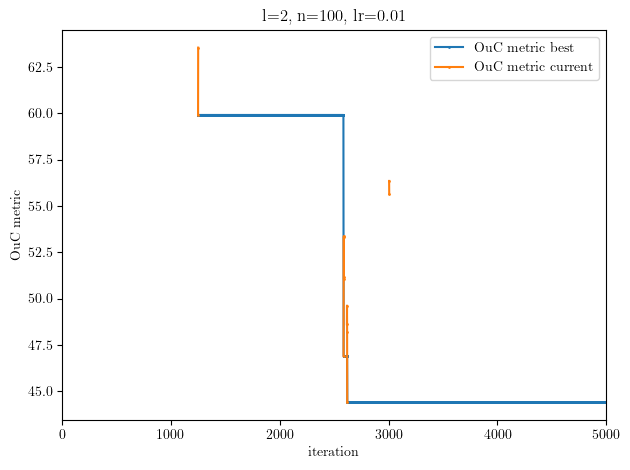

In [29]:
plt.plot(res_3['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res_3['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res_3["layers"]}, n={res_3["neurons"]}, lr={res_3["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

[1.8224612474441528, 5.8480939865112305, 4.432797431945801, 3.9824373722076416, 3.0234930515289307, 2.251800060272217, 2.5749716758728027, 3.814631938934326, 5.786741256713867, 10.21430778503418]


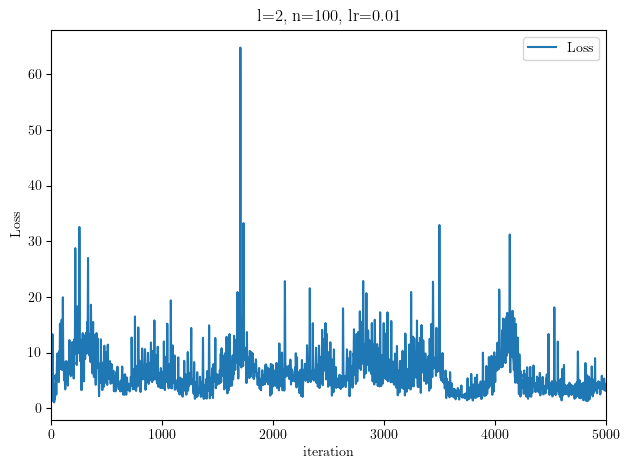

In [30]:
print(L_loss[:10])

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res_3["layers"]}, n={res_3["neurons"]}, lr={res_3["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

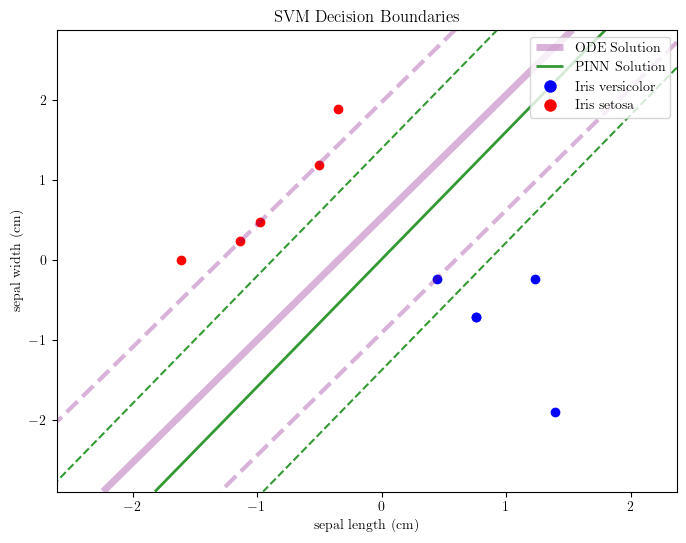

Variables: [ 1.1508055  -0.72098637  0.00780138  0.3286171   0.81868005  0.71357393
  0.31338754  0.3922032   0.43066752  0.34326404  0.2102125   0.757434
  0.03900928]
Constraints: [-0.79919344 -2.7916431  -1.1734449  -0.00054647 -1.1510332  -0.8227978
 -1.1877367  -0.8053489  -1.1495643  -0.46676427 -0.3286171  -0.81868005
 -0.71357393 -0.31338754 -0.3922032  -0.43066752 -0.34326404 -0.2102125
 -0.757434   -0.03900928]


In [31]:
net = res_3['net_best']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))

4th ITERATION:

In [32]:
xu0 = jnp.array(res_)

y0 = res_

Time: 0.18505001068115234
objective: inf
Dual variables (alpha): [ 1.06710188 -0.72006478  0.3923362   0.00863577 -0.00640963  0.0081779
 -0.02183933  0.01420144  0.01076797  0.01085056  0.01209805 -0.00287793
  0.00444854]
Constraints: [ 0.00064097 -2.2331076  -0.00118569 -0.0126527  -0.3576908  -0.7233778
 -0.33606362 -0.888526   -0.70973194 -0.00430994 -0.00863577  0.00640963
 -0.0081779   0.02183933 -0.01420144 -0.01076797 -0.01085056 -0.01209805
  0.00287793 -0.00444854]
max diff: 0.06643772 mean diff: 0.06643772


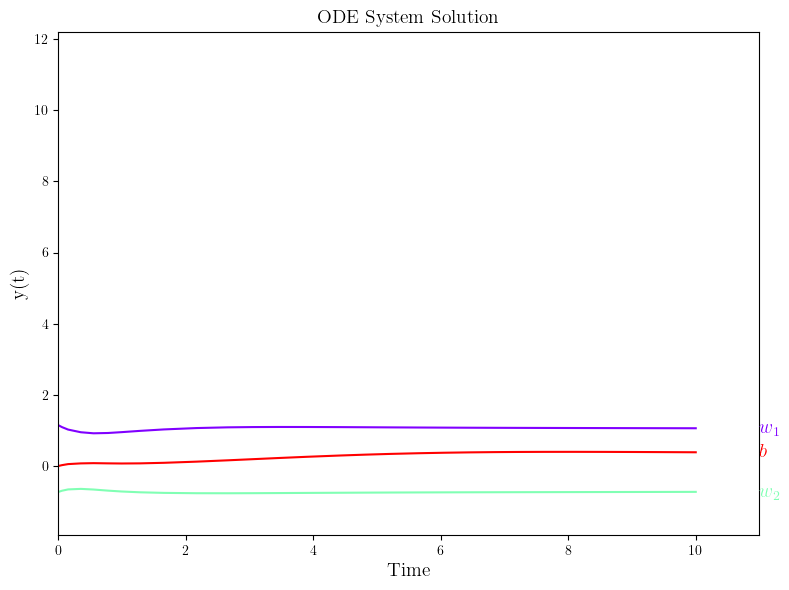

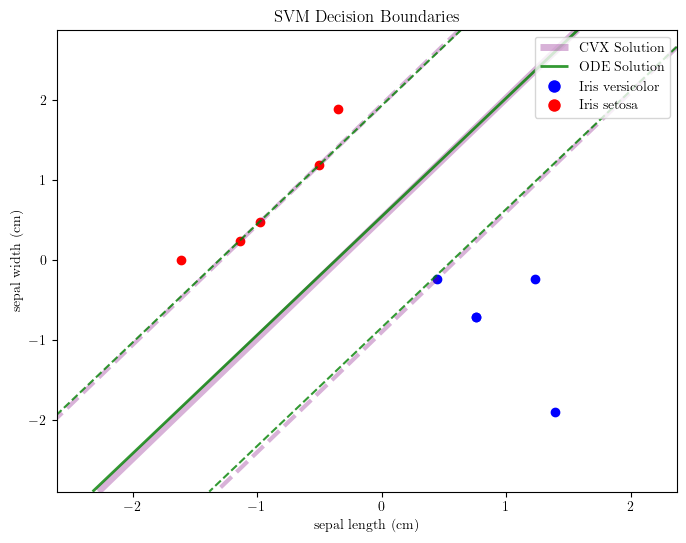

In [33]:
sol, result = solve_ODE(xu0, 10)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [34]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t = example.NN_method() # train
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'time:', t)
res_4 = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net_best': net_best, 'net_curr': net_curr, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 16.070599 time: 415.55544781684875


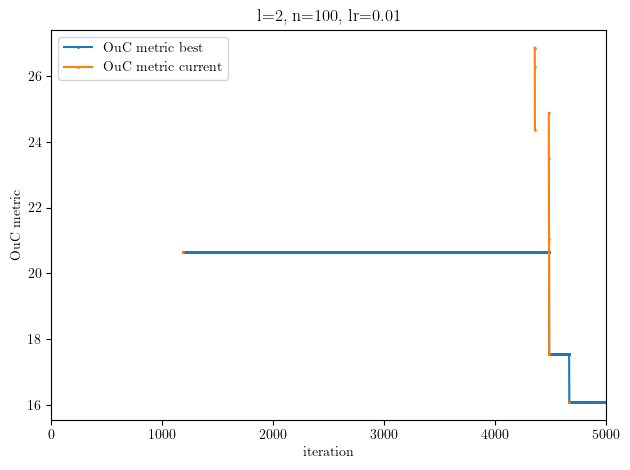

In [35]:
plt.plot(res_4['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res_4['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res_4["layers"]}, n={res_4["neurons"]}, lr={res_4["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

[6.835187911987305, 13.853854179382324, 47.44083786010742, 64.62455749511719, 62.642242431640625, 53.47716522216797, 39.036048889160156, 27.13164520263672, 16.15766143798828, 13.381343841552734]


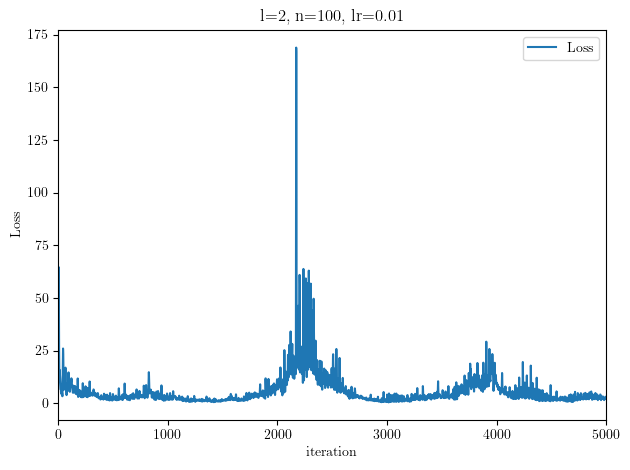

In [36]:
print(L_loss[:10])

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res_4["layers"]}, n={res_4["neurons"]}, lr={res_4["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

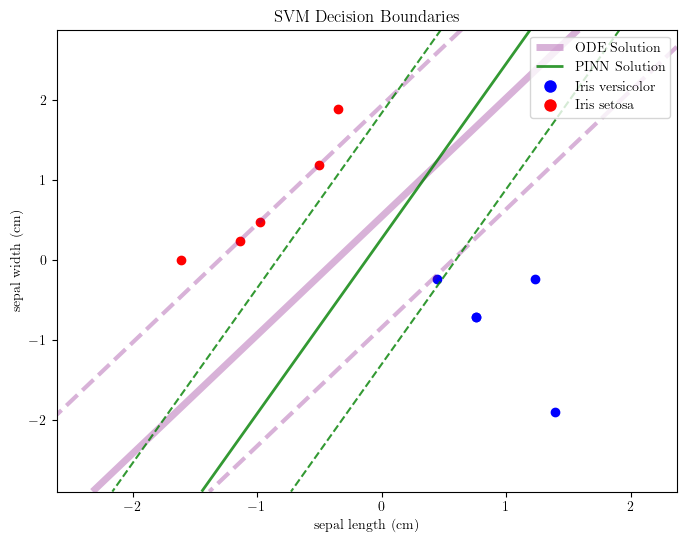

Variables: [ 1.3937526  -0.6366997   0.17120707  0.14144251  0.32260817  0.06854439
  0.09309866  0.09231782  0.22056213  0.26855588  0.18144469  0.0692327
  0.03185658]
Constraints: [-0.70465964 -2.636517   -0.5627416  -0.0310282  -0.61226    -0.9001807
 -1.3406574  -1.2190353  -0.74885124 -0.31899405 -0.14144251 -0.32260817
 -0.06854439 -0.09309866 -0.09231782 -0.22056213 -0.26855588 -0.18144469
 -0.0692327  -0.03185658]


In [37]:
net = res_4['net_best']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))